#### grid '.44': annual object frequency of EUR-44/EUR-11 vs CERRA
 - 'Evaluation': 1990-2010, 3 datasets 

  - 1 Read griid file
  - 2 Read CERRA Objs
  - 3 'Evaluation'   vs. CERRA

In [1]:
import os
import datetime
import numpy as np
from netCDF4 import Dataset
import pandas as pd
 
import string
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy 
import cartopy.crs as ccrs

#### 0 setup

In [10]:
proj = ccrs.PlateCarree()
type_s = ['evaluation']
Objects = ['Precipitation', 'jet stream', 'cyclone', 'anticyclone', 'cyclone_z500', 'anticyclone_z500' ] 
n_obj = len(Objects)

In [47]:
def rd_objs(Objects, dir_d, dataname, year_s, year_e, n_obj, nx, ny):
    n_year = year_e - year_s + 1
    annualObjectFrequency = np.zeros((n_year, nx, ny, n_obj))
    annualObjectFrequency[:] = np.nan
    
    for year in range(year_s, year_e + 1):
        flnm = dir_d  + '/'+ str(year) + '_' + dataname + '_annual_allFeature_frequ.npz'
        # this file is calculated from cal_obj_freq_cerra.ipynb             
        #print('read:',flnm)
        DATA = np.load(flnm)
                 
        mean_pr = DATA['mean_pr']
        mean_jet = DATA['mean_jet']
        mean_cy = DATA['mean_cy']
        mean_acy = DATA['mean_acy']
        mean_cy_z500 = DATA['mean_cy_z500']
        mean_acy_z500 = DATA['mean_acy_z500'] 
     
        nn = year - year_s
    
        annualObjectFrequency[nn,:,:,Objects.index('Precipitation')] = DATA['mean_pr']
        annualObjectFrequency[nn,:,:,Objects.index('jet stream')] = DATA['mean_jet']
        annualObjectFrequency[nn,:,:,Objects.index('cyclone')] = DATA['mean_cy']
        annualObjectFrequency[nn,:,:,Objects.index('anticyclone')] = DATA['mean_acy'] 
        annualObjectFrequency[nn,:,:,Objects.index('cyclone_z500')] = DATA['mean_cy_z500']
        annualObjectFrequency[nn,:,:,Objects.index('anticyclone_z500')] = DATA['mean_acy_z500']
    return  np.nanmean(annualObjectFrequency, axis = 0)*365


In [48]:
def plot_obj(Objects, res, type_s, Lat, Lon, dataset, ObjectFrequency):
    '''
    res: '44' or '11'
    type_s = 'evaluation', 'historical' or 'rcp'
    dataset: list of dataset name('ECMWF-ERAINT_evaluation_r1i1p1_CLMcom-CCLM5-0-6',
             'ECMWF-ERAINT_evaluation_r1i1p1_UCAN-WRF331G',...)
    ObjectFrenquency: np.zeros((n_dataset,nx, ny, n_obj)
    '''
    # Objects = ['Cyclones','Anticyclones','Precipitation','Fronts','AR', 'MS'] 
    MIN = 1

    #level_s = np.arange(0,12,1)
    
    n_ds = len(dataset)
 
    if n_ds == 4 :
        nrow = int(np.ceil(n_ds/2))
        ncol = 2
        x_fig = 12
        y_fig = 8
    else:
        nrow = int(np.ceil(n_ds/3))
        ncol = 3
        x_fig = 20
        y_fig = 10
    
    for obj in range(n_obj):
        fig, ax = plt.subplots(nrow, ncol, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(x_fig,y_fig))
        print('---------', type_s, Objects[obj], '---------')
        if Objects[obj] == 'Precipitation':
           level_s = np.arange(0, 14, 1)
        elif  Objects[obj] == 'jet stream' or Objects[obj] == 'cyclone' \
                or Objects[obj] == 'cyclone_z500' :
            level_s = np.arange(0, 100, 10)        
        elif  Objects[obj] == 'anticyclone' or Objects[obj] == 'anticyclone_z500':
            level_s = np.arange(0, 160, 10)

        
        for ds in range(n_ds):
            nr = int(ds/ncol)
            nc = int((ds%ncol))
        
            DATAse = ObjectFrequency[ds,:,:,Objects.index(Objects[obj])]
            DATAse[DATAse < MIN] = np.nan  
            
            if nrow != 1:
                #If extend= 'neither', values outside the levels range are not colored
                im=ax[nr,nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                        extend='both', cmap='RdYlBu_r', levels=level_s)
                fig.colorbar(im, ax=ax[nr,nc], shrink=0.9, location="bottom")
                ax[nr,nc].coastlines()
                ax[nr,nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nr][nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nr][nc].gridlines(draw_labels=True)  
            else:
                im=ax[nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                               levels=level_s[obj], cmap='RdYlBu_r', extend='both')
                fig.colorbar(im, ax=ax[nr,nc], shrink=0.9)
                ax[nc].coastlines()
                ax[nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nc].gridlines(draw_labels=True) 
                
            # remove empty extra plot
            if n_ds == 5:
                ax[1,2].set_axis_off()
                
        fig.suptitle(Objects[obj], fontsize=20)        
        #plt.savefig('PDF/' + Objects[obj] + '_' + type_s + '_' + res + '.pdf')  
        plt.tight_layout()
        plt.show()

In [49]:
def plot_obj_diff_44(Objects, res, type_s, Lat, Lon, dataset, ObjectFrequency):
    '''
    res: '44' 
    type_s = 'evaluation', 'historical' or 'rcp'
    dataset: list of dataset name('ECMWF-ERAINT_evaluation_r1i1p1_CLMcom-CCLM5-0-6',
            'ECMWF-ERAINT_evaluation_r1i1p1_UCAN-WRF331G',...)
    ObjectFrenquency: np.zeros((n_dataset,nx, ny, n_obj)
    '''
     
    n_ds = len(dataset)
 
    nrow = int(np.ceil(n_ds/3))
    ncol = 3
    
    if n_ds == 3:
        x_fig = 20
        y_fig = 5.5
    else:
        x_fig = 20
        y_fig = 10
  
    for obj in range(n_obj):
        fig, ax = plt.subplots(nrow, ncol, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(x_fig,y_fig))
        
        level_s = range(-100,110,10) 
            
        for ds in range(n_ds):
            nr = int(ds/ncol)
            nc = int((ds%ncol))
        
            DATAse = ObjectFrequency[ds,:,:,Objects.index(Objects[obj])]
             
            if nrow != 1:
                im=ax[nr,nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                               levels=level_s, extend='both', cmap='RdBu_r')
                fig.colorbar(im, ax=ax[nr,nc], shrink=0.9, location="bottom")
                ax[nr,nc].coastlines()
                ax[nr,nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nr][nc].set_title(dataset[ds] + '- CERRA' , wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nr][nc].gridlines(draw_labels=True)  
                
            else:
                im=ax[nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                               levels=level_s, extend='both', cmap='RdBu_r')
                fig.colorbar(im, ax=ax[nc], shrink=0.9,location="bottom")
                ax[nc].coastlines()
                ax[nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nc].set_title(dataset[ds] + ' - CERRA', wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nc].gridlines(draw_labels=True)
            
            # remove empty extra plot
            if nrow != 1:
                ax[1,2].set_axis_off()

        fig.suptitle(Objects[obj], fontsize=30) 
        plt.tight_layout() 
        #plt.savefig('PDF/' + Objects[obj] + '_' + type_s + '_' + res + '_diff.pdf')  
         
        plt.show()

#### 1 Read Grid file

In [50]:
# Target grid resolusion
res_TarGrid = '44'

# 'EUR-44','EUR-11','CERRA'
res_EUR = 'EUR-44'

# name of analyzed dataset EUR-44
if res_EUR == 'EUR-44':
    DataName_1d = ['CLMcom-CCLM5-0-6_v1', 'MOHC-HadGEM3-RA_v1','UCAN-WRF331G_v01']
elif res_EUR == 'EUR-11':
    # name of analyzed dataset EUR-11
    DataName_1d = ['CLMcom-ETH-COSMO-crCLIM-v1-1_v1', \
                'MOHC-HadREM3-GA7-05_v1',\
                'ICTP-RegCM4-6_v1']
else:
    DataName_1d = ['CERRA']

n_dataset = len(DataName_1d)

dir_d = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.' + res_TarGrid +'/'
dir_cerra = dir_d + 'CERRA/'
dir_eval = dir_d + res_EUR + '/'
 
# OLD dir_o = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/'
dir_o = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/PAPER/'

# for all datasets  
year_s = 1990
year_e = 2010
n_year = year_e - year_s + 1
days = 365

flnm = dir_cerra + '201001_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc'
ncid = Dataset(flnm)
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
nx = Lon.shape[0]
ny = Lon.shape[1]
ncid.close()
print('grid is from ', flnm, nx, ny)

grid is from  /glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/201001_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc 92 187


#### 2 Read CERRA Objs

In [51]:
# ObjectFrequency_allwill be appended to ObjectFrequency in axis = 0
ObjectFrequency_all = np.zeros((n_dataset + 1, nx, ny, n_obj))
ObjectFrequency_all[:] = np.nan

annualObjectFrequency = rd_objs(Objects, dir_cerra  + 'annual_feature_frequ/', 'CERRA', year_s, year_e, n_obj, nx, ny)
     
# annual average
ObjectFrequency_all[n_dataset] = annualObjectFrequency


/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-44//annual_feature_frequ/
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-44//annual_feature_frequ/
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-44//annual_feature_frequ/
--------- Evaluation Precipitation ---------


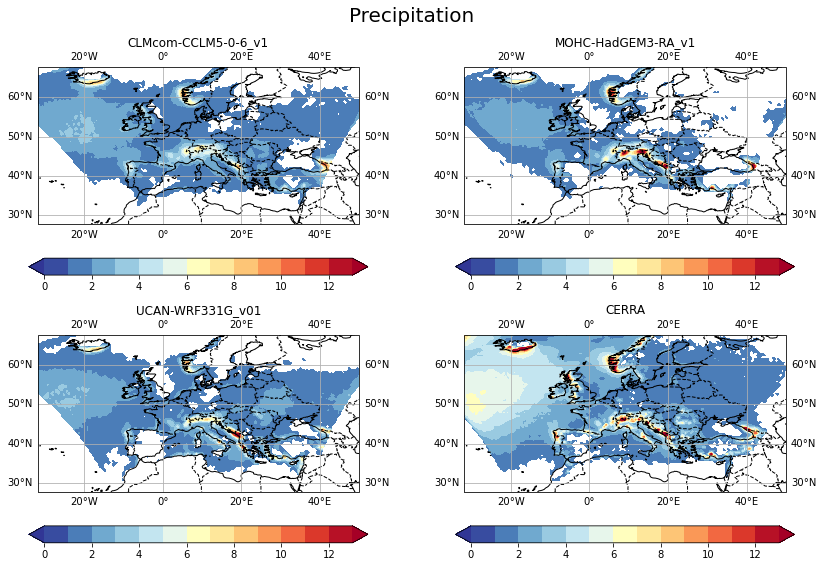

--------- Evaluation jet stream ---------


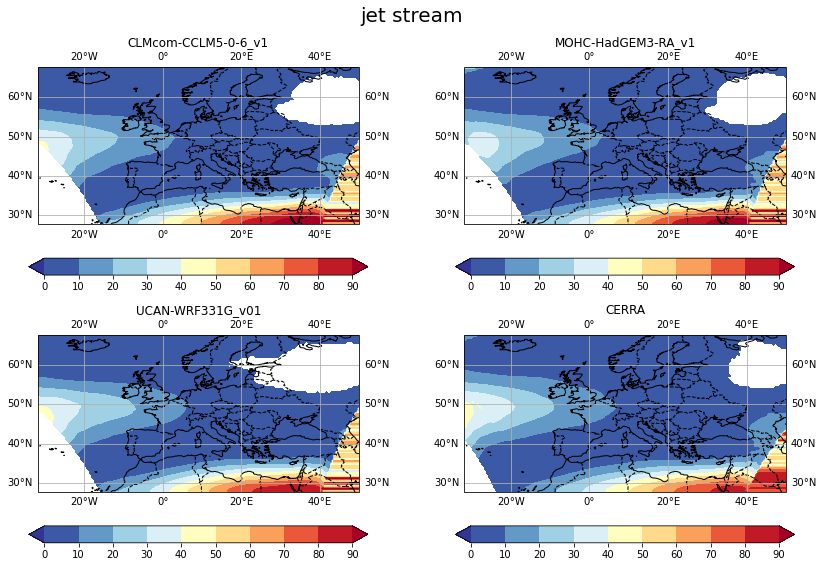

--------- Evaluation cyclone ---------


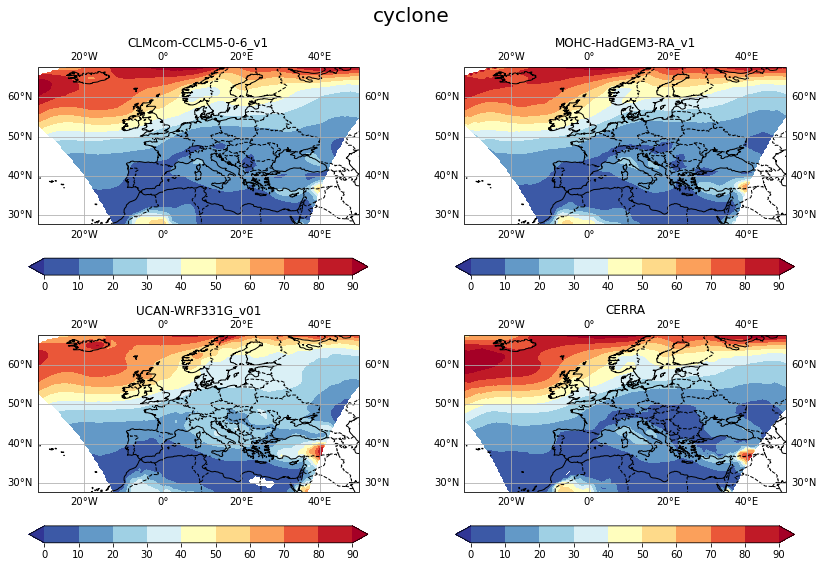

--------- Evaluation anticyclone ---------


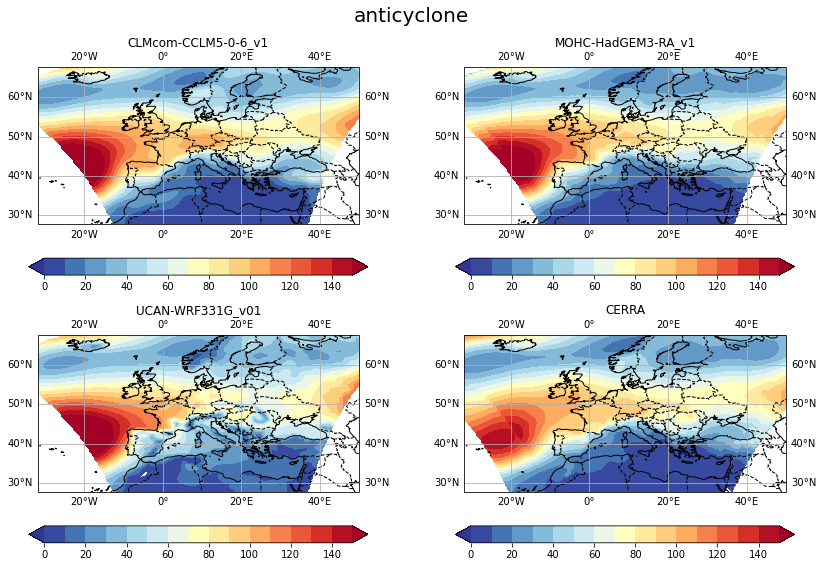

--------- Evaluation cyclone_z500 ---------


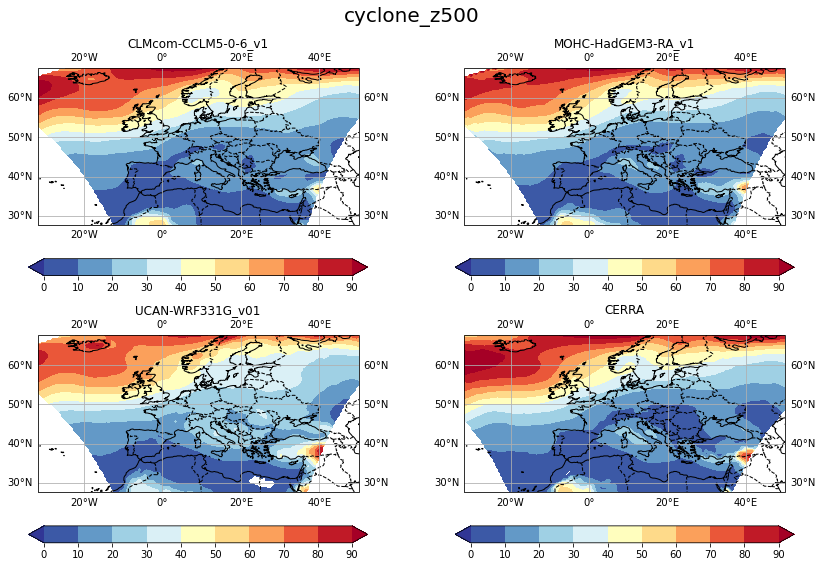

--------- Evaluation anticyclone_z500 ---------


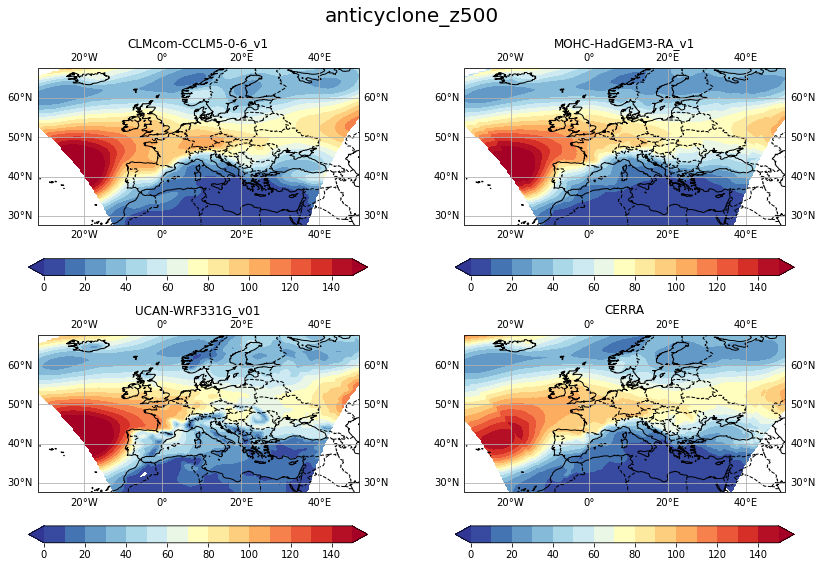

In [52]:
ct = 0
for dataname in DataName_1d:
    dir_data = dir_eval + '/'  + 'annual_feature_frequ/'
    print(dir_data)
    ObjectFrequency_all[ct] = rd_objs(Objects, dir_data, dataname, year_s, year_e, n_obj, nx, ny)
    ct = ct + 1

plot_obj(Objects, '44', 'Evaluation', Lat, Lon, DataName_1d + ['CERRA'], ObjectFrequency_all)    

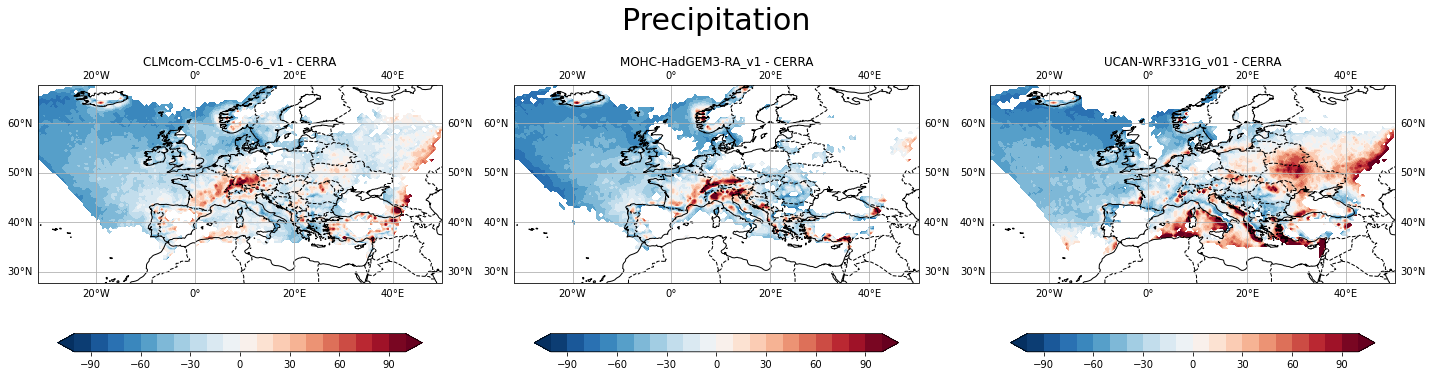

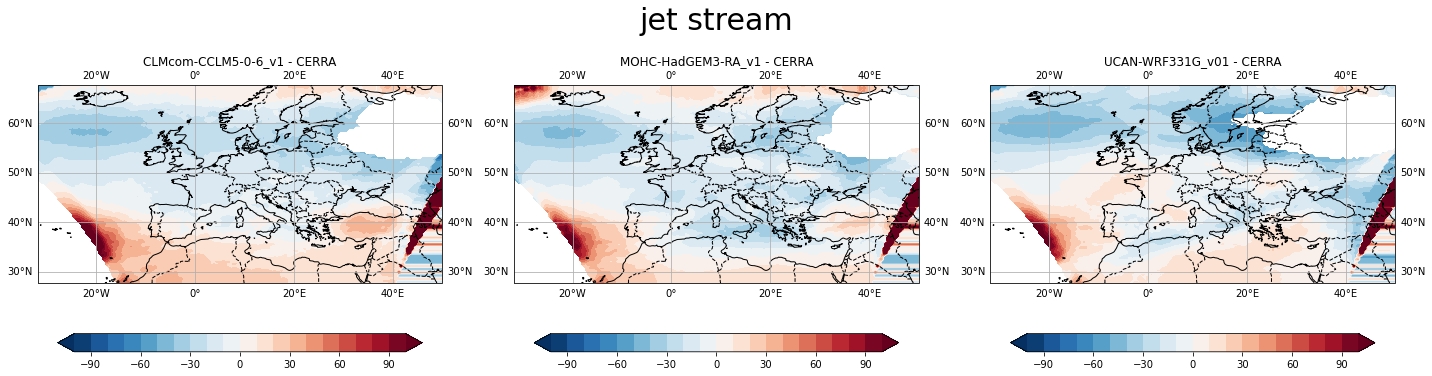

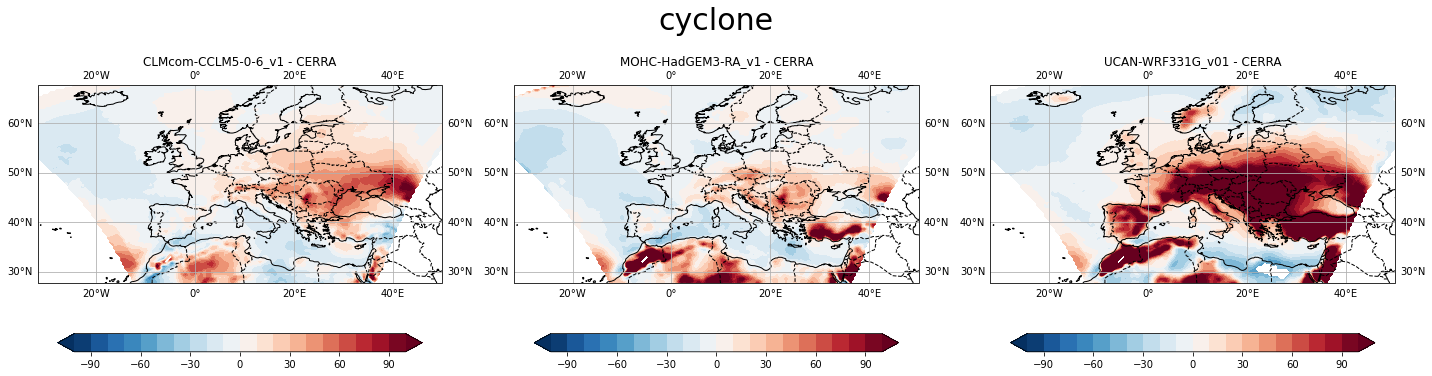

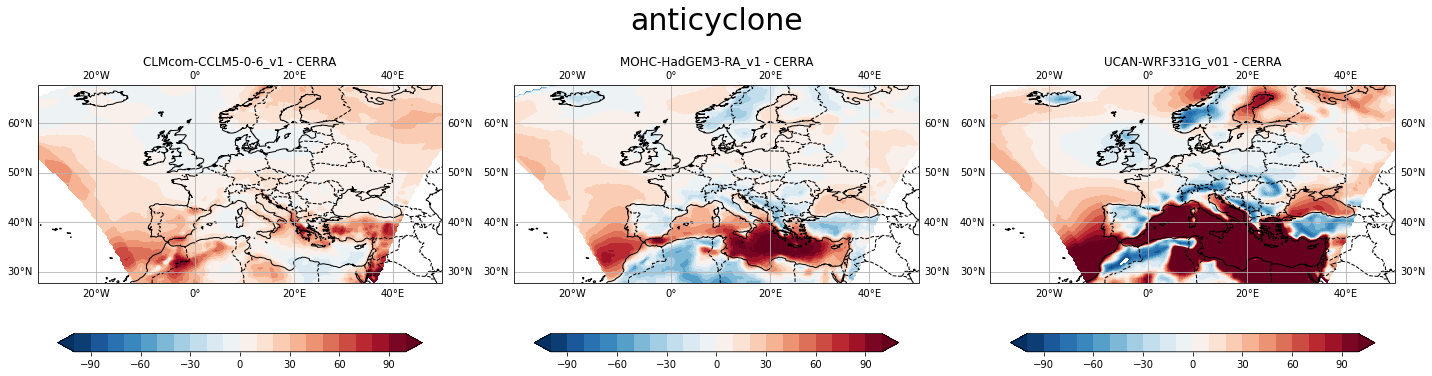

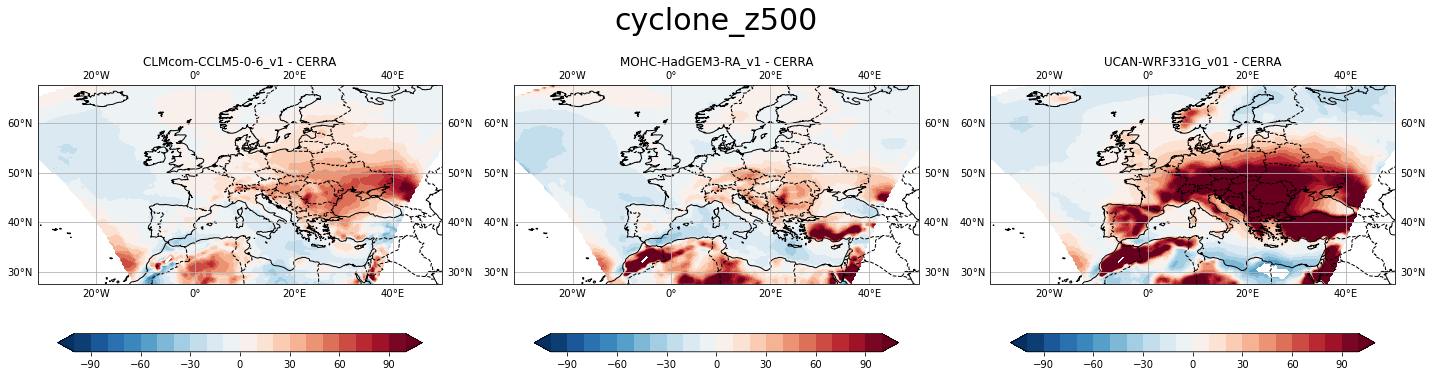

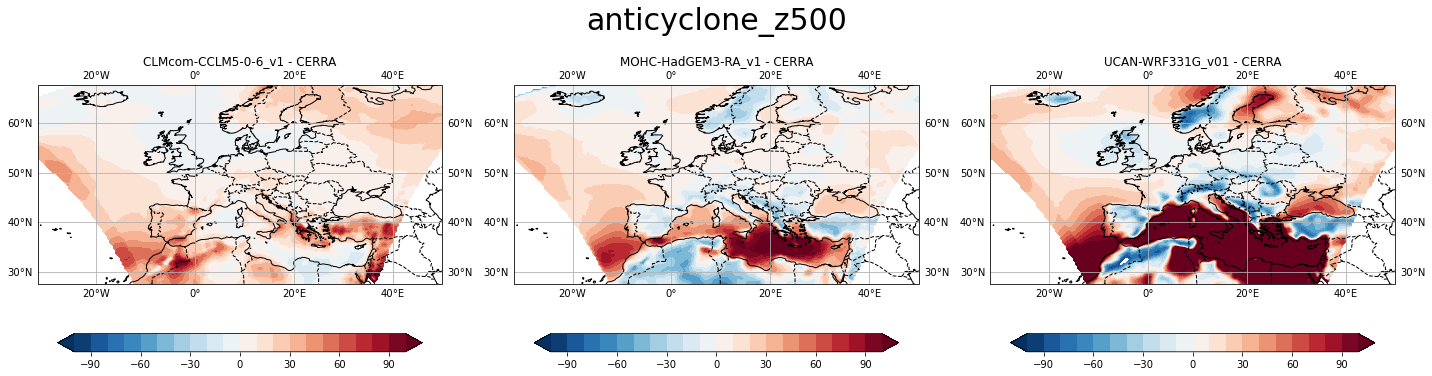

In [53]:
for nd in range(len(DataName_1d)):
    ObjectFrequency_all[nd,:,:,:] = (ObjectFrequency_all[nd,:,:,:] - ObjectFrequency_all[-1]) \
                                    / ObjectFrequency_all[-1] * 100      
    
plot_obj_diff_44( Objects, '44', 'Evaluation EUR-44', Lat, Lon, DataName_1d, ObjectFrequency_all[:-1])    


#### precipitation object annual frequency EUR-11 vs. CERRA
 and their difference (EUR-11 - CERRA)

/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-11//annual_feature_frequ/
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-11//annual_feature_frequ/
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-11//annual_feature_frequ/
--------- Evaluation Precipitation ---------


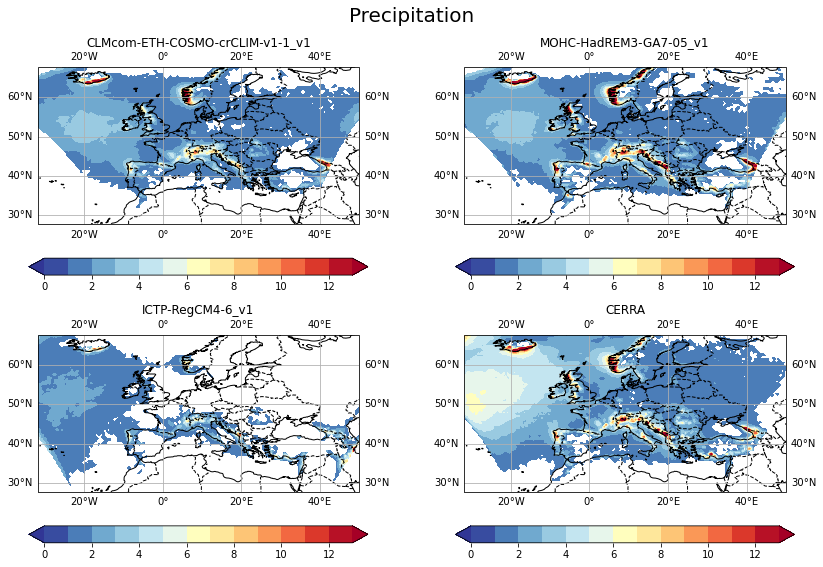

--------- Evaluation jet stream ---------


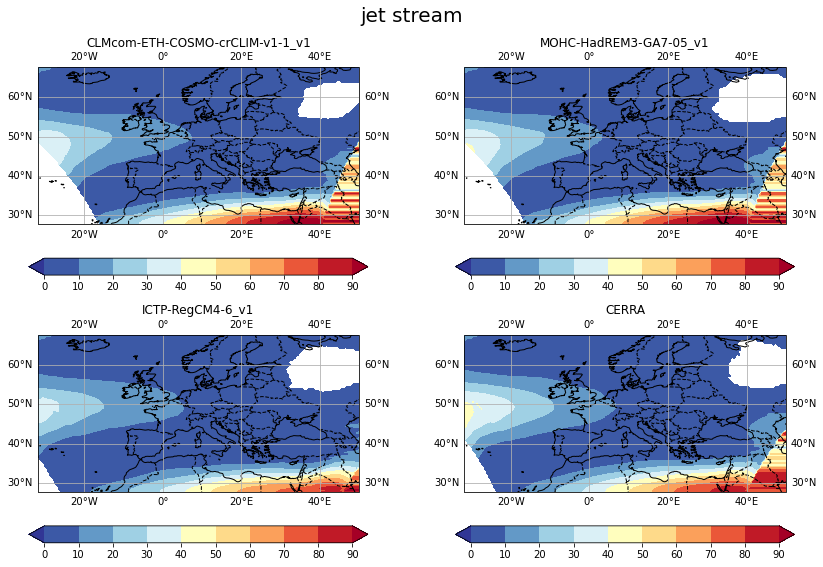

--------- Evaluation cyclone ---------


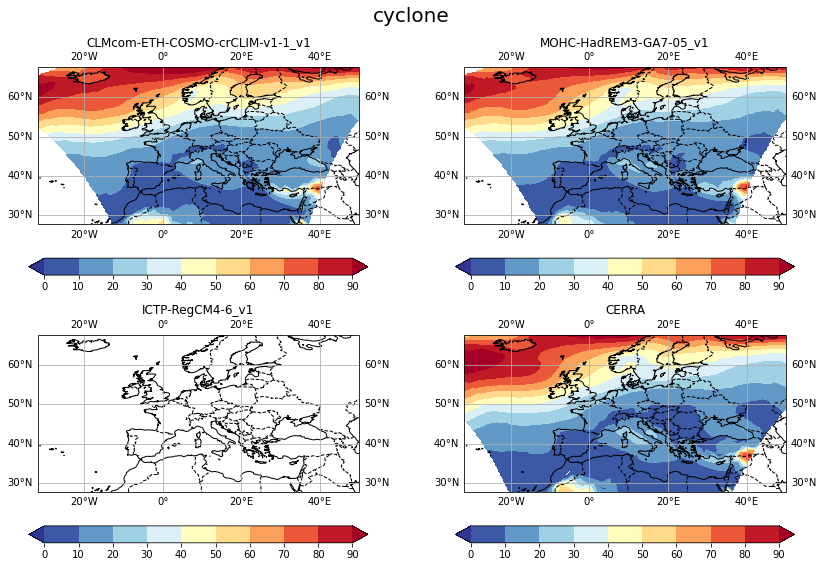

--------- Evaluation anticyclone ---------


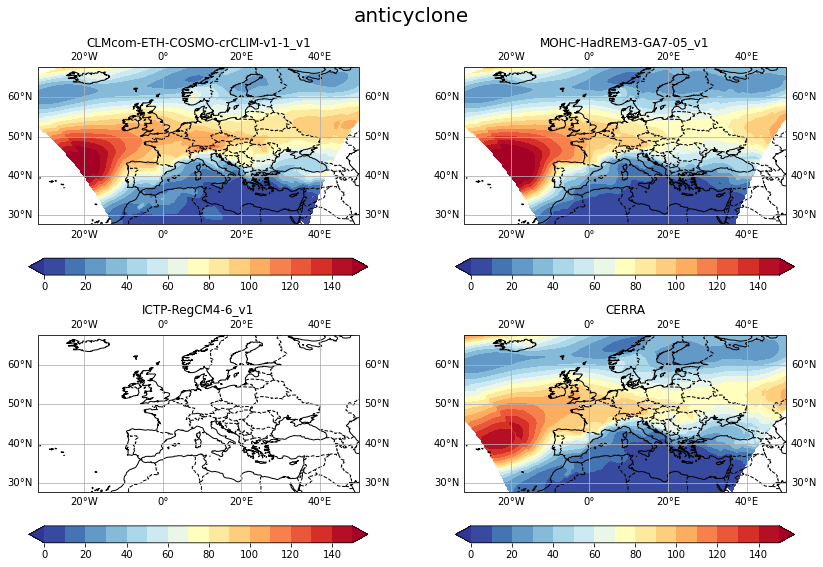

--------- Evaluation cyclone_z500 ---------


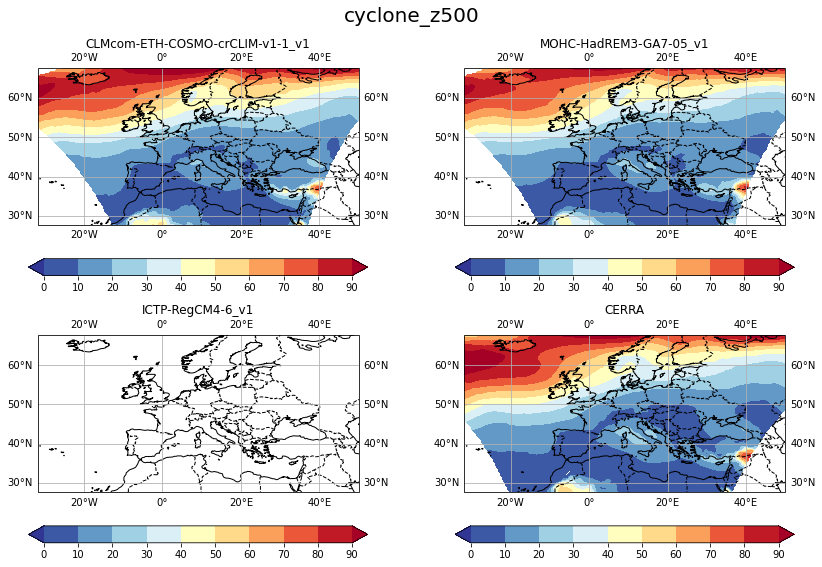

--------- Evaluation anticyclone_z500 ---------


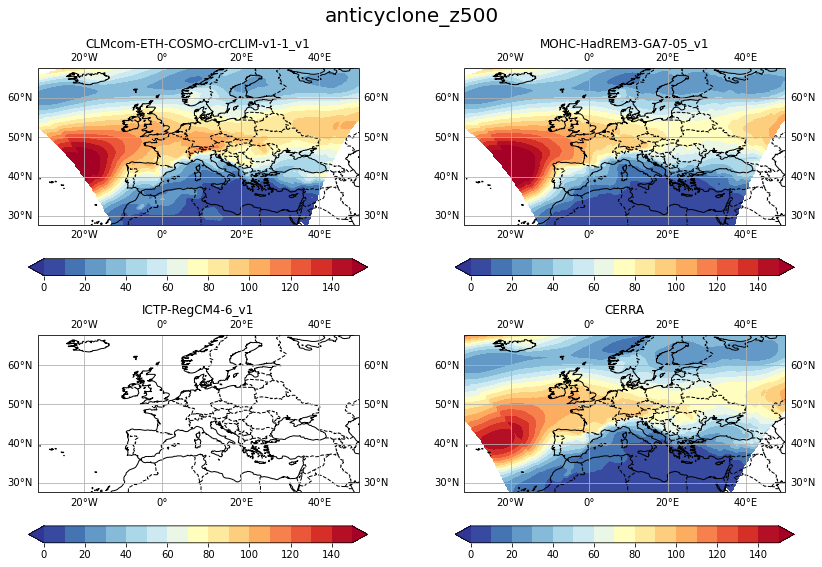

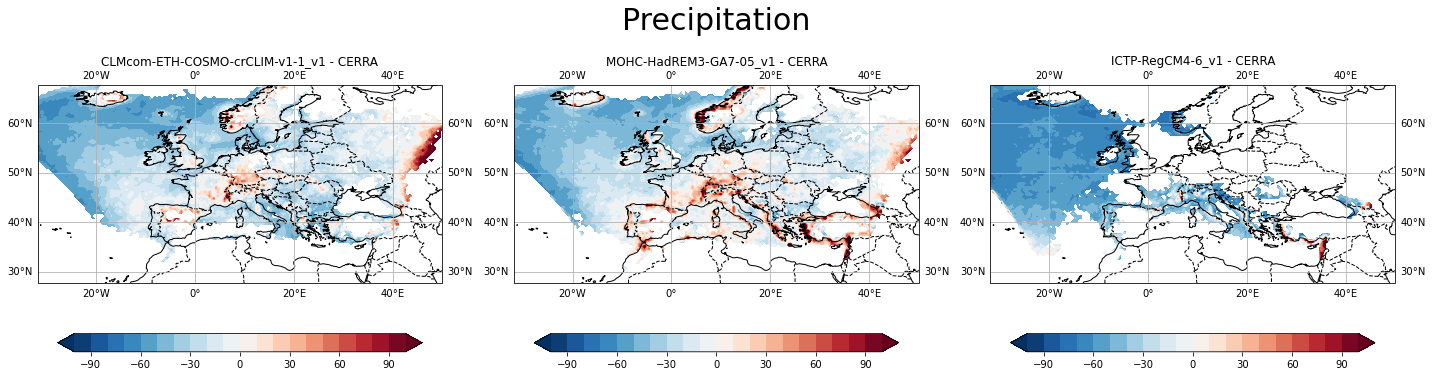

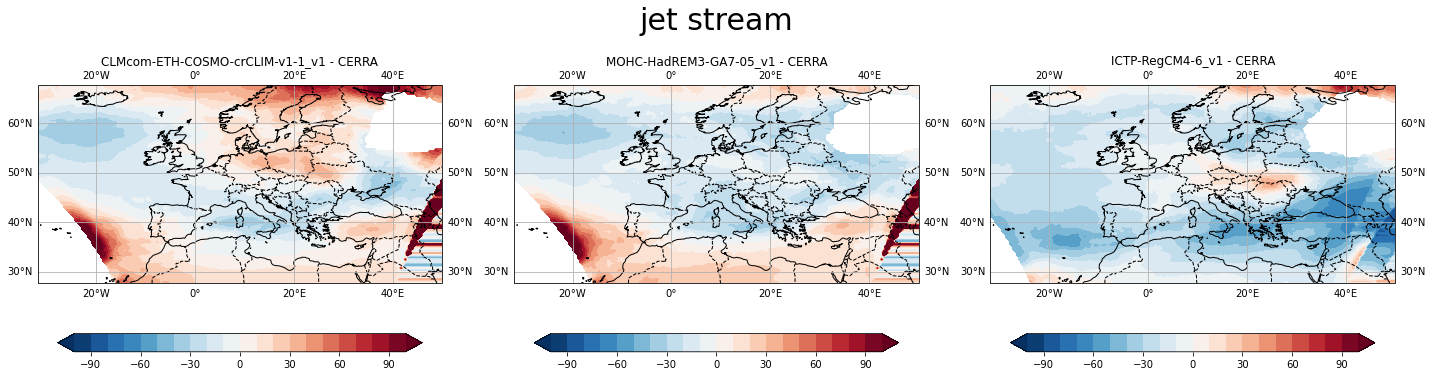

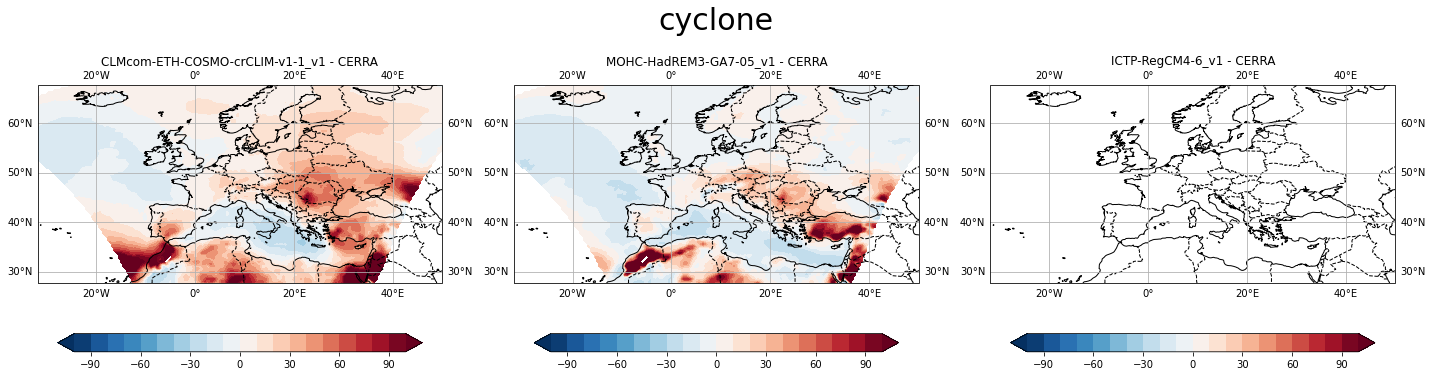

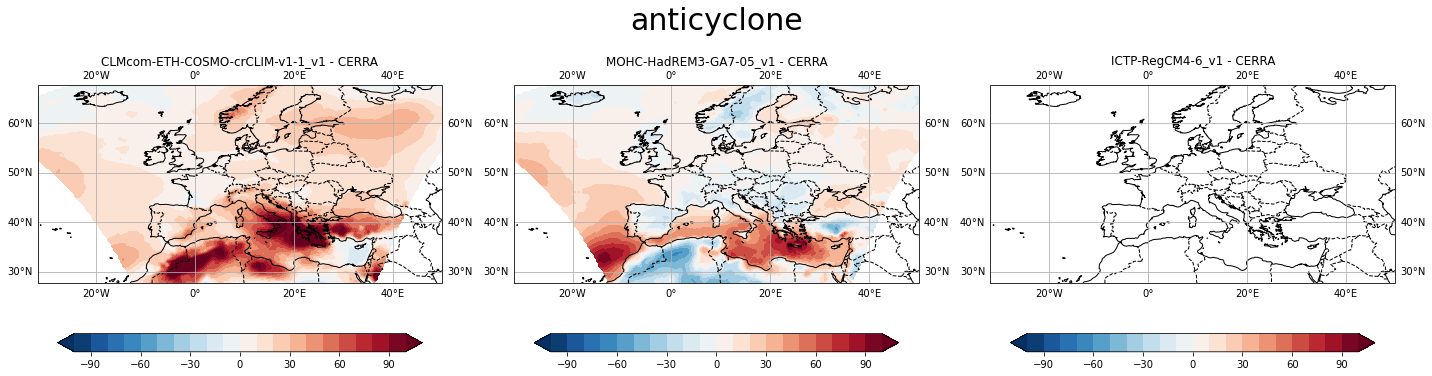

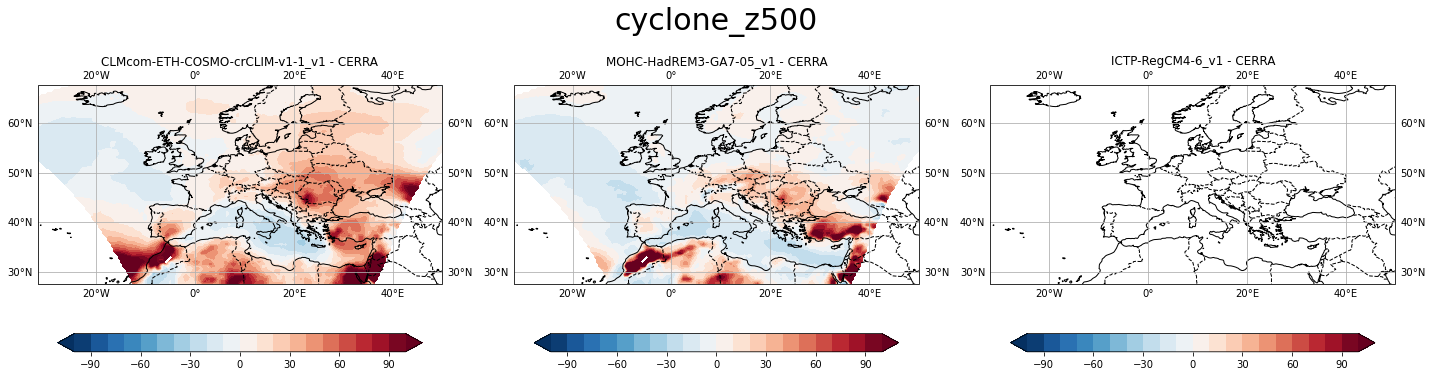

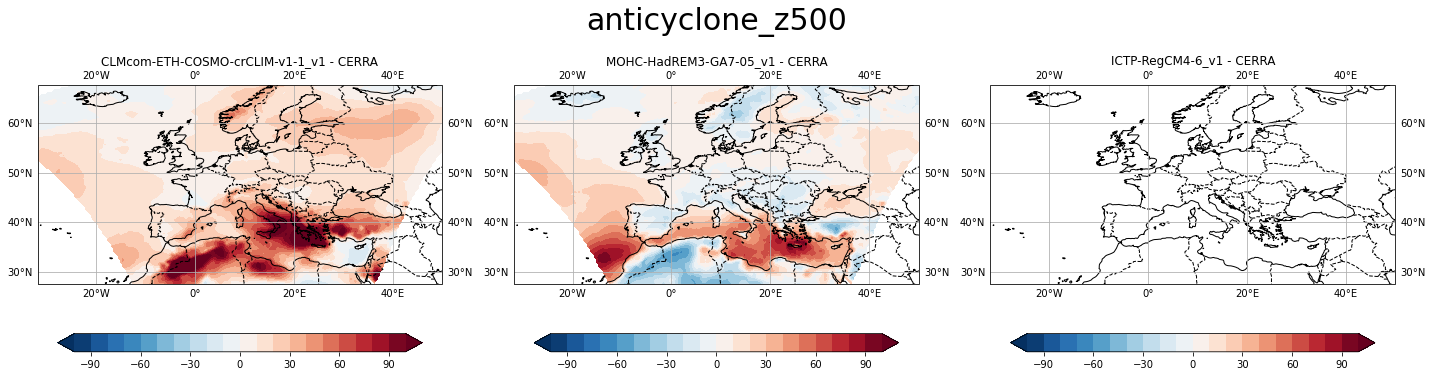

In [54]:
res_EUR = 'EUR-11'
dir_eval = dir_d + res_EUR + '/'

DataName_1d = ['CLMcom-ETH-COSMO-crCLIM-v1-1_v1', \
                'MOHC-HadREM3-GA7-05_v1',\
                'ICTP-RegCM4-6_v1']

ct = 0
for dataname in DataName_1d:
    dir_data = dir_eval + '/'  + 'annual_feature_frequ/'
    print(dir_data)
    ObjectFrequency_all[ct] = rd_objs(Objects, dir_data, dataname, year_s, year_e, n_obj, nx, ny)
    ct = ct + 1

plot_obj(Objects, '44', 'Evaluation', Lat, Lon, DataName_1d + ['CERRA'], ObjectFrequency_all)    

for nd in range(len(DataName_1d)):
    ObjectFrequency_all[nd,:,:,:] = (ObjectFrequency_all[nd,:,:,:] - ObjectFrequency_all[-1]) \
                                    / ObjectFrequency_all[-1] * 100      
    
plot_obj_diff_44(Objects, '44', 'Evaluation EUR-11', Lat, Lon, DataName_1d, ObjectFrequency_all[:-1])    
